# **Import packages and load data**

In [60]:
import pickle 
import numpy as np
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

plt.style.use("seaborn-v0_8-whitegrid")

In [61]:
synt_data_dir = r"data\synthetic_data"

data_file = "dataloan_log_['choose_procedure']_100000_train_normal.csv"
# data_file = "dataloan_log_['choose_procedure', 'set_ir_3_levels']_100000_train_normal.csv"
# data_file = "dataloan_log_['set_ir_3_levels']_100000_train_normal.csv"
file_path = osp.join(synt_data_dir, data_file)

# rct_data_file = "dataloan_log_['choose_procedure']_100000_train_RCT.csv"
rct_data_file = "dataloan_log_['choose_procedure', 'set_ir_3_levels']_100000_train_RCT.csv"
rct_file_path = osp.join(synt_data_dir, rct_data_file)

In [62]:
with open(file_path, 'rb') as f:
    train_normal = pickle.load(f)

with open(rct_file_path, 'rb') as f:
    train_rct = pickle.load(f)

In [63]:
# data_file_interv1 = "dataloan_log_['choose_procedure']_100000_train_normal.csv"
# with open(osp.join(synt_data_dir, data_file_interv1), 'rb') as f:
#     train_normal_interv1 = pickle.load(f)
# (train_normal_interv1 == train_normal).sum(axis=0)

# **Exploratory Data Analysis**

In [64]:
from collections import OrderedDict

stoi = OrderedDict()
itos = OrderedDict()
cat_features = ['activity']
# special_tokens = {"<PAD>": 0, "<UNK>": 1, "<EOS>": 2}

# Process each categorical feature
for feature in cat_features:
    unique_values = sorted(train_normal[feature].unique().tolist())

    stoi[feature] = {} #special_tokens.copy()
    itos[feature] = {} #special_tokens.copy()

    # itos[feature] = {
    #     idx: token for token, idx in special_tokens.items()
    # }

    for idx, value in enumerate(unique_values, start=0): #len(special_tokens)
        stoi[feature][value] = idx
        itos[feature][idx] = value
itos

OrderedDict([('activity',
              {0: 'calculate_offer',
               1: 'call_customer',
               2: 'cancel_application',
               3: 'contact_headquarters',
               4: 'email_customer',
               5: 'initiate_application',
               6: 'receive_acceptance',
               7: 'receive_refusal',
               8: 'skip_contact',
               9: 'start_priority',
               10: 'start_standard',
               11: 'validate_application'})])

C:\Users\sahat\AppData\Local\Temp\ipykernel_30692\3680278599.py:15: RuntimeWarning: invalid value encountered in divide
  normalized_adjacency = adjacency / adjacency.sum(axis=1, keepdims=True)


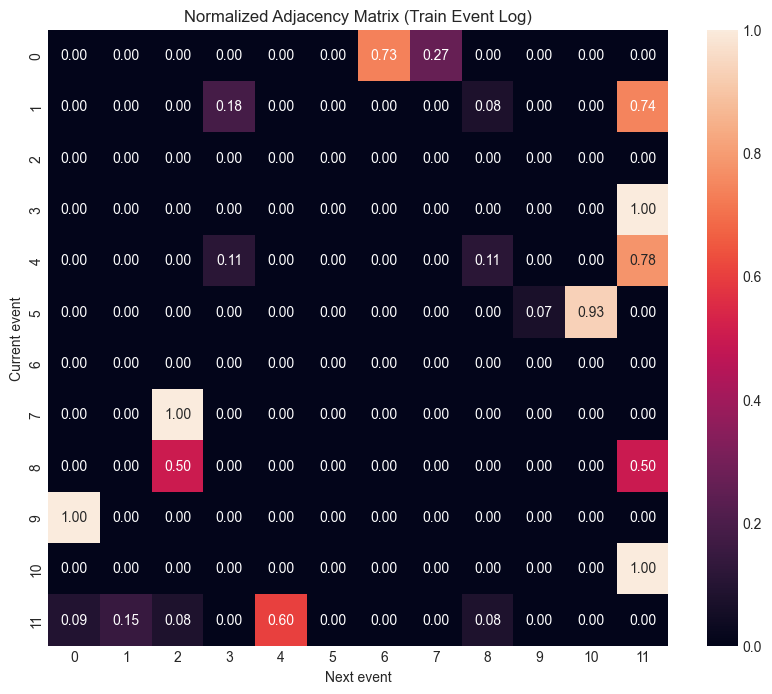

In [65]:
# n_rows = len(special_tokens) + train_normal['activity'].nunique()
# n_cols = len(special_tokens) + train_normal['activity'].nunique()
n_rows = train_normal['activity'].nunique()
n_cols = train_normal['activity'].nunique()
adjacency = np.zeros((n_rows, n_cols), dtype=int)

for case_id, group in train_normal.groupby('case_nr'):
    activities = group['activity'].values    
    for i in range(len(activities) - 1):
        activity1 = activities[i]
        activity2 = activities[i + 1]
        # print(activity1, activity2)
        adjacency[stoi['activity'][activity1] , stoi['activity'][activity2]] += 1

normalized_adjacency = adjacency / adjacency.sum(axis=1, keepdims=True)
normalized_adjacency = np.nan_to_num(normalized_adjacency).astype(np.float64)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(normalized_adjacency, annot=True, fmt=".2f", )
ax.set_title('Normalized Adjacency Matrix (Train Event Log)')
ax.set_xlabel('Next event')
ax.set_ylabel('Current event')
plt.show()

Trace lengths

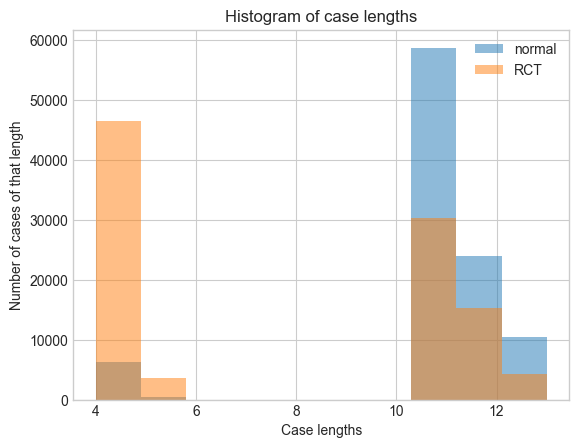

In [66]:
ax = train_normal.groupby("case_nr")["activity"].count().hist(color="tab:blue", alpha=0.5, label='normal')
train_rct.groupby("case_nr")["activity"].count().hist(color="tab:orange", ax=ax, alpha=0.5, label='RCT')
ax.set_xlabel("Case lengths")
ax.set_ylabel("Number of cases of that length")
ax.set_title("Histogram of case lengths")
plt.legend()
plt.show()

In [67]:
agg_len = train_normal.groupby("case_nr")["activity"].count().isin([4, 5])
short_case_ids = np.where(agg_len ==  True)[0]
short_cases = train_normal[train_normal["case_nr"].isin(short_case_ids)]
print("Number of short cases:", short_case_ids.shape[0])

# Check if in all short cases start_priority activity executed
are_priority_cases = short_cases.groupby("case_nr")["activity"].agg(list).apply(lambda x: "start_priority" in x)
print("Number of short cases with 'start_priority' activity:", are_priority_cases.sum())

print("All short cases started with priority procedure:  ", short_case_ids.shape[0] == are_priority_cases.sum())

Number of short cases: 6663
Number of short cases with 'start_priority' activity: 6663
All short cases started with priority procedure:   True


Label distribution

In [68]:
last_activities = train_normal.sort_values(["case_nr", "timestamp"], ascending=True) \
                              .groupby("case_nr")["activity"] \
                              .last() 

# Divide cases for cancelled and accepted by the last activity

cancelled_case_ids = last_activities[last_activities == 'cancel_application'].index
cancelled_cases = train_normal[train_normal["case_nr"].isin(cancelled_case_ids)]
accepted_cases = train_normal[~train_normal["case_nr"].isin(cancelled_case_ids)]

print("Number of accepted cases:", accepted_cases.shape[0])
print("Number of cancelled cases:", cancelled_cases.shape[0])
print(f"Total number of cases is equal to train_normal ({train_normal.shape[0]}):", 
      cancelled_cases.shape[0] + accepted_cases.shape[0] == train_normal.shape[0])


Number of accepted cases: 313652
Number of cancelled cases: 785201
Total number of cases is equal to train_normal (1098853): True


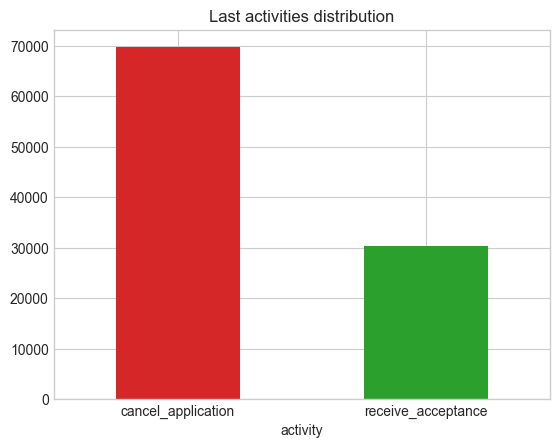

In [69]:
ax = last_activities.value_counts().plot.bar(color=["tab:red", "tab:green"], rot=0, x="last activity");
ax.set_title("Last activities distribution");

Number of cases with priority procedure vs standard one

In [70]:
agg_activities = train_normal.groupby('case_nr')["activity"].agg(list)

In [71]:
# Taking cases where application was processed with a priority procedure

priority_case_ids = agg_activities[agg_activities.apply(lambda lst: "start_priority" in lst)].index.to_list()

priority_cases = train_normal[train_normal["case_nr"].isin(priority_case_ids)]
standard_cases = train_normal[~train_normal["case_nr"].isin(priority_case_ids)]

Text(0.5, 1.0, 'Ratio of priority and standard cases in the outcome')

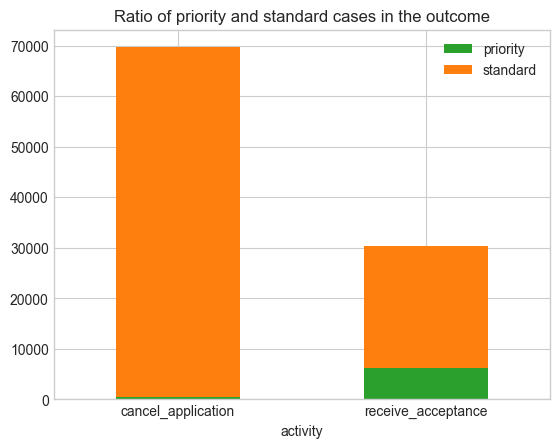

In [72]:
# Analysing outputs of the standard and priority cases

priority_outcomes = priority_cases.groupby("case_nr")["activity"].last().value_counts()
standard_outcomes = standard_cases.groupby("case_nr")["activity"].last().value_counts()
case_outcomes = pd.concat([priority_outcomes, standard_outcomes], keys=['priority', 'standard']).unstack()

ax = case_outcomes.transpose().plot.bar(stacked=True, color=['tab:green', 'tab:orange'], rot=0)
ax.set_title("Ratio of priority and standard cases in the outcome")

## **Analysis of case with canceled applications**

Estimate "calculate_offer" activities with the high interest rate 


In [73]:
in_rate_result = train_normal.loc[:, ["case_nr", "activity", "interest_rate"]].groupby("case_nr").aggregate({"interest_rate": 'unique',
                                                                                                             "activity": lambda x: x.to_list()})
in_rate_result["last_activity"] = in_rate_result['activity'].apply(lambda x: x[-1])

In [74]:
in_rate_result["interest_rate"] = in_rate_result["interest_rate"].apply({'activity': lambda x: np.nan_to_num(x)}).values

In [75]:
# in_rate_result.loc[:, ["interest_rate",  "last_activity"]].plot.bar()

priority_in_rate = in_rate_result.iloc[priority_case_ids]
std_in_rate = in_rate_result[~in_rate_result.index.isin(priority_in_rate.index)]

In [76]:
priority_in_rate["interest_rate"] = priority_in_rate["interest_rate"].apply(lambda x: x.sum()); 
std_in_rate["interest_rate"] = std_in_rate["interest_rate"].apply(lambda x: x.sum()); 

C:\Users\sahat\AppData\Local\Temp\ipykernel_30692\3517179730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  priority_in_rate["interest_rate"] = priority_in_rate["interest_rate"].apply(lambda x: x.sum());
C:\Users\sahat\AppData\Local\Temp\ipykernel_30692\3517179730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_in_rate["interest_rate"] = std_in_rate["interest_rate"].apply(lambda x: x.sum());


In [77]:
priority_bar_plot = priority_in_rate.groupby(['interest_rate', 'last_activity']).size().reset_index(name='frequency')
priority_pivot_df = priority_bar_plot.pivot_table(
    index='interest_rate', 
    columns='last_activity', 
    values='frequency', 
    aggfunc='sum'
)

std_bar_plot = std_in_rate.groupby(['interest_rate', 'last_activity']).size().reset_index(name='frequency')
std_pivot_df = std_bar_plot.pivot_table(
    index='interest_rate', 
    columns='last_activity', 
    values='frequency', 
    aggfunc='sum'
)

All  the cases with cancelled appllication and 0 interest rate have "skip_contact" activity

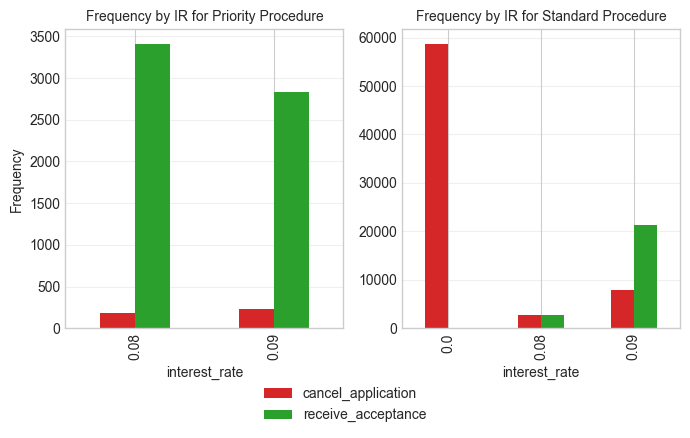

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
priority_pivot_df.plot(kind='bar', ax=axs[0], width=0.5, legend=False, color=['tab:red', 'tab:green'])
std_pivot_df.plot(kind='bar', ax=axs[1], width=0.5, legend=False,  color=['tab:red', 'tab:green'])

# Customize the plot
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency by IR for Priority Procedure', fontsize=10)
axs[1].set_title('Frequency by IR for Standard Procedure', fontsize=10)
axs[0].grid(axis='y', alpha=0.3)
axs[1].grid(axis='y', alpha=0.3)
handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.1), loc='lower center', )
axs[0].legend().remove()
axs[1].legend().remove()

plt.tight_layout()
plt.show()

In [79]:
skipped_hq_std_ids = std_in_rate[(std_in_rate['last_activity'] == 'cancel_application') & (std_in_rate['interest_rate']==0.0)].reset_index(drop=False)['case_nr']

skipped_hq_std_cases =  train_normal[train_normal['case_nr'].isin(skipped_hq_std_ids)]
print("Number of standard cases with  'skip_contact' (interest_rate  is abscent):", skipped_hq_std_ids.shape[0])

ir_009_std_ids = std_in_rate[(std_in_rate['last_activity'] == 'cancel_application') & (std_in_rate['interest_rate']==0.09)].reset_index(drop=False)['case_nr']
print("Number of standard cases with  interest_rate==0.09:", ir_009_std_ids.shape[0])

ir_008_std_ids = std_in_rate[(std_in_rate['last_activity'] == 'cancel_application') & (std_in_rate['interest_rate']==0.08)].reset_index(drop=False)['case_nr']
print("Number of standard cases with  interest_rate==0.08:", ir_008_std_ids.shape[0])

Number of standard cases with  'skip_contact' (interest_rate  is abscent): 58771
Number of standard cases with  interest_rate==0.09: 7799
Number of standard cases with  interest_rate==0.08: 2711


In [80]:
foi = ["case_nr", "activity", "amount", "quality", "unc_quality", "est_quality",
       "interest_rate", "discount_factor", "timestamp", "elapsed_time"]
cancelled_cases_red = cancelled_cases.loc[:, foi]

In [81]:
# Extracting standard cases among cancelled ones 
st_cancelled_cases = cancelled_cases_red[cancelled_cases_red.index.isin(standard_cases.index)] 
st_cancelled_cases_num = st_cancelled_cases.groupby("case_nr").count().shape[0]
print("Total number of cancelled cases with the standard procedure:", st_cancelled_cases_num)

Total number of cancelled cases with the standard procedure: 69281


In [82]:
# Estimating how many cases that got offered a loan are there among standard cancelled cases

case_ids_w_calc_offer = st_cancelled_cases[st_cancelled_cases["activity"] == "calculate_offer"]["case_nr"]
case_w_calc_offer_num = case_ids_w_calc_offer.shape[0]
print("Number of cancelled cases with 'calculate_offer' activity: ", case_w_calc_offer_num)

case_ids_w_skip_cont = st_cancelled_cases[st_cancelled_cases["activity"] == "skip_contact"]["case_nr"]
case_w_skip_cont_num = case_ids_w_skip_cont.shape[0]
print("Number of cancelled cases with 'skip_contact' activity: ", case_w_skip_cont_num)

st_cancelled_w_calc_offer = st_cancelled_cases[st_cancelled_cases["case_nr"].isin(case_ids_w_calc_offer)]
st_cancelled_w_skip_contact = st_cancelled_cases[st_cancelled_cases["case_nr"].isin(case_ids_w_skip_cont)]

print("Number of cases that have not been included in any group:", st_cancelled_cases_num - case_w_calc_offer_num - case_w_skip_cont_num)

Number of cancelled cases with 'calculate_offer' activity:  10510
Number of cancelled cases with 'skip_contact' activity:  58771
Number of cases that have not been included in any group: 0


Create a ground truth sample, where "skip_contact" caused the application being **cancelled** due to the multiple client contacts. Thus, "skip_contact" is a change point in a given control-flow.

In [83]:
skipped_hq_std_cases = skipped_hq_std_cases.loc[:, foi].reset_index(drop=True)
temp_df = skipped_hq_std_cases.groupby('case_nr')['activity'].agg(list).apply(lambda lst: [i for i, el  in enumerate(lst) if el  == 'skip_contact'])
temp_df = temp_df.rename('change_point_pos')
labeled_std_cancelled_skipped = skipped_hq_std_cases.join(temp_df, on='case_nr', how='left',validate='m:1')


In [84]:
output_path = r'D:\PycharmProjects\xAI-PPM\output\synth_data_with_gt_change_points'

labeled_std_cancelled_skipped.to_csv(osp.join(output_path, "std_cancelled_with_skipped_hq_cases.csv"))

## **Analysis of case with accepted applications**


Estimate impact of "contact_headquarters" activity to the outcome

In [85]:
train_w_contact_hq_ids = agg_activities[agg_activities.apply(lambda lst: "contact_headquarters" in lst)].index
train_w_contact_hq = train_normal[train_normal["case_nr"].isin(train_w_contact_hq_ids)]

last_activities_hq = train_w_contact_hq.groupby("case_nr")['activity'].last()
cancelled_w_contact_hq_ids = last_activities_hq[last_activities_hq == 'cancel_application'].index
cancelled_w_contact_hq = train_w_contact_hq[train_w_contact_hq["case_nr"].isin(cancelled_w_contact_hq_ids)]
accepted_w_contact_hq = train_w_contact_hq[~train_w_contact_hq["case_nr"].isin(cancelled_w_contact_hq_ids)]

print("Number of cases with accepted applications after 'contact_hq':", train_w_contact_hq_ids.shape[0] - cancelled_w_contact_hq_ids.shape[0])
print("Number of cases with cancelled applications after 'contact_hq':", cancelled_w_contact_hq_ids.shape[0])

Number of cases with accepted applications after 'contact_hq': 24056
Number of cases with cancelled applications after 'contact_hq': 10510


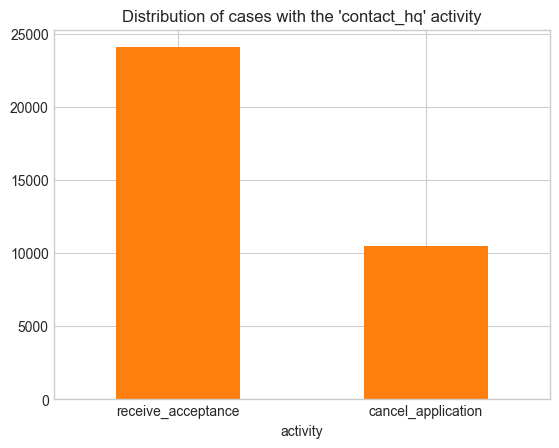

In [86]:
ax = last_activities_hq.value_counts().plot.bar(rot=0, color='tab:orange');
ax.set_title("Distribution of cases with the 'contact_hq' activity");

In [87]:
from typing import List

def get_cp_for_contact_hq_cases(activities:  List[str]):
    change_points = []
    for i, activity in enumerate(activities):
        if activity == 'contact_headquarters':
            change_points.append(i)
        elif activity =='calculate_offer':
            change_points.append(i)
    return change_points

temp_df = accepted_w_contact_hq.groupby('case_nr')['activity'].agg(list).apply(get_cp_for_contact_hq_cases).rename('change_point_pos')
labeled_std_accepted_contact_hq = accepted_w_contact_hq.join(temp_df, on='case_nr', how='left',validate='m:1')

In [88]:
labeled_std_accepted_contact_hq.to_csv(osp.join(output_path, "std_accepted_with_contact_hq_cases.csv"))

In [89]:
temp_df = cancelled_w_contact_hq.groupby('case_nr')['activity'].agg(list).apply(get_cp_for_contact_hq_cases).rename('change_point_pos')
labeled_std_cancelled_contact_hq = cancelled_w_contact_hq.join(temp_df, on='case_nr', how='left',validate='m:1')

In [90]:
labeled_std_cancelled_contact_hq.to_csv(osp.join(output_path, "std_cancelled_with_contact_hq_cases.csv"))

In [91]:
labeled_std_cancelled_contact_hq

,case_nr,activity,amount,quality,unc_quality,est_quality,cum_cost,interest_rate,discount_factor,outcome,noc,nor,min_interest_rate,timestamp,elapsed_time,change_point_pos
68,6,initiate_application,57360,3,1,2,0,NaN,NaN,-1690.0,0,0,NaN,2024-05-04 12:48:00,0.000000,"[4, 10]"
69,6,start_standard,57360,3,1,2,10,NaN,NaN,-1690.0,0,0,NaN,2024-05-04 15:12:00,0.100000,"[4, 10]"
70,6,validate_application,57360,3,1,2,30,NaN,NaN,-1690.0,0,0,NaN,2024-05-05 15:12:00,1.100000,"[4, 10]"
71,6,call_customer,57360,3,0,3,50,NaN,NaN,-1690.0,1,0,NaN,2024-05-06 08:00:00,1.800000,"[4, 10]"
72,6,contact_headquarters,57360,3,0,3,1050,NaN,NaN,-1690.0,1,0,NaN,2024-05-06 22:24:00,2.400000,"[4, 10]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098355,99954,email_customer,38387,2,0,2,1100,NaN,NaN,-1660.0,3,0,NaN,4079-07-12 12:52:10,4.802894,"[4, 10]"
1098356,99954,validate_application,38387,2,0,2,1120,NaN,NaN,-1660.0,3,0,NaN,4079-07-13 08:04:10,5.602894,"[4, 10]"
1098357,99954,calculate_offer,38387,2,0,2,1520,0.09,0.07,-1660.0,3,0,0.08,4079-07-16 08:00:00,8.600000,"[4, 10]"
1098358,99954,receive_refusal,38387,2,0,2,1530,0.09,0.07,-1660.0,3,1,0.08,4079-07-17 08:00:00,9.600000,"[4, 10]"


# **Segment synthetic log**

In [109]:
import ruptures as rpt
from ruptures.metrics import randindex, precision_recall
from local_xai.trace_segmentation.transition_based import TransitionCost, segment_trace

#### Test segmentation on one trace

In [93]:
def map_to_tokens(activities):
    return [stoi['activity'][activity] for activity in activities]

In [94]:
test_case =  labeled_std_accepted_contact_hq[labeled_std_accepted_contact_hq['case_nr']==0]
test_trace =  test_case['activity']
test_tokens = np.asarray(map_to_tokens(test_trace))
gt_test_breapoints  =  test_case['change_point_pos'][0]  + [len(test_tokens)]
print("Ground truth change points for the trace are", gt_test_breapoints)

Ground truth change points for the trace are [4, 10, 12]


In [95]:
custom_cost=TransitionCost(normalized_adjacency)
seg_result = segment_trace(test_tokens, custom_cost)
print("Found breakpoints {} with the penalty {}".format(seg_result['breakpoints'], seg_result['penalty']))
print('RandIndex is', randindex(seg_result['breakpoints'], gt_test_breapoints))


Found breakpoints [4, 10, 12] with the penalty 0.99
RandIndex is 1.0


## Evaluate segmentation for the given sample of traces

Segmentation of accepted cases with standard procedure and "contact_headquarters" activity

In [124]:
accepted_contact_hq_traces =  labeled_std_accepted_contact_hq.groupby('case_nr')[['activity', 'change_point_pos']].aggregate(list)
accepted_contact_hq_traces['tokens'] = accepted_contact_hq_traces['activity'].apply(lambda x: map_to_tokens(x))
accepted_contact_hq_traces['change_point_pos'] = accepted_contact_hq_traces['change_point_pos'].apply(lambda x: x[0] + [len(x)])
gt_brkps_accepted_hq = accepted_contact_hq_traces['change_point_pos']

In [125]:
criterion = TransitionCost(normalized_adjacency)

segmentation_results1 = {'breakpoints': [], 'penalties': []}

for trace in tqdm(accepted_contact_hq_traces['tokens'][:100]):
    trace  = np.asarray(trace)
    result = segment_trace(trace, criterion)
    segmentation_results1['breakpoints'].append(result['breakpoints'])
    segmentation_results1['penalties'].append(result['penalty'])


100%|██████████| 100/100 [00:02<00:00, 44.49it/s]


In [126]:
rankindex_result = [randindex(brkps, gt_brkps) for brkps, gt_brkps in zip(segmentation_results1['breakpoints'], gt_brkps_accepted_hq)]
print("Average RankIndex of the sample of accepted cases after 'contact_hq':", np.mean(rankindex_result).round(4))

pr_result = [precision_recall(gt_bkpts, bkpts, margin=1) for gt_bkpts, bkpts in zip(gt_brkps_accepted_hq, segmentation_results1['breakpoints'])]
f1_scores  = [(2 * pr * rec) / (pr + rec) for pr, rec in pr_result]
print("Average F1-score of the sample of accepted cases after 'contact_hq':", np.mean(f1_scores).round(4))

Average RankIndex of the sample of accepted cases after 'contact_hq': 0.9536
Average F1-score of the sample of accepted cases after 'contact_hq': 0.88


Segmentation of cancelled cases with standard procedure and "contact_headquarters" activity

In [132]:
cancelled_contact_hq_traces =  labeled_std_cancelled_contact_hq.groupby('case_nr')[['activity', 'change_point_pos']].aggregate(list)
cancelled_contact_hq_traces['tokens'] = cancelled_contact_hq_traces['activity'].apply(lambda x: map_to_tokens(x))
cancelled_contact_hq_traces['change_point_pos'] = cancelled_contact_hq_traces['change_point_pos'].apply(lambda x: x[0] + [len(x)])
gt_brkps_cancelled_hq = cancelled_contact_hq_traces['change_point_pos']

In [133]:
segmentation_results2 = {'breakpoints': [], 'penalties': []}

for trace in tqdm(cancelled_contact_hq_traces['tokens'][:100]):
    trace  = np.asarray(trace)
    result = segment_trace(trace, criterion)
    segmentation_results2['breakpoints'].append(result['breakpoints'])
    segmentation_results2['penalties'].append(result['penalty'])

100%|██████████| 100/100 [00:02<00:00, 46.72it/s]


In [135]:
rankindex_result = [randindex(brkps, gt_brkps) for brkps, gt_brkps in zip(segmentation_results2['breakpoints'], gt_brkps_cancelled_hq)]
print("Average RankIndex of the sample of accepted cases after 'contact_hq':", np.mean(rankindex_result).round(4))

pr_result = [precision_recall(gt_bkpts, bkpts, margin=1) for gt_bkpts, bkpts in zip(gt_brkps_cancelled_hq, segmentation_results2['breakpoints'])]
f1_scores  = [(2 * pr * rec) / (pr + rec) for pr, rec in pr_result]
print("Average F1-score of the sample of accepted cases after 'contact_hq':", np.mean(f1_scores).round(4))

Average RankIndex of the sample of accepted cases after 'contact_hq': 0.9019
Average F1-score of the sample of accepted cases after 'contact_hq': 0.7


Segmentation of cases with  standard procedure and "skip_contact" activity

In [136]:
cancelled_skip_contact_traces =  labeled_std_cancelled_skipped.groupby('case_nr')[['activity', 'change_point_pos']].aggregate(list)
cancelled_skip_contact_traces['tokens'] = cancelled_skip_contact_traces['activity'].apply(lambda x: map_to_tokens(x))
cancelled_skip_contact_traces['change_point_pos'] = cancelled_skip_contact_traces['change_point_pos'].apply(lambda x: x[0] + [len(x)])
gt_brkpts_canc_skip_hq = cancelled_skip_contact_traces['change_point_pos']

In [138]:
segmentation_results3 = {'breakpoints': [], 'penalties': []}

for trace in tqdm(cancelled_skip_contact_traces['tokens'][:100]):
    trace  = np.asarray(trace)
    result = segment_trace(trace, criterion)
    segmentation_results3['breakpoints'].append(result['breakpoints'])
    segmentation_results3['penalties'].append(result['penalty'])

100%|██████████| 100/100 [00:02<00:00, 42.75it/s]


In [139]:
rankindex_result = [randindex(brkps, gt_brkps) for brkps, gt_brkps in zip(segmentation_results3['breakpoints'], gt_brkpts_canc_skip_hq)]
print("Average RankIndex of the sample of cancelled cases with 'skip_contact':", np.mean(rankindex_result).round(4))

pr_result = [precision_recall(gt_bkpts, bkpts, margin=1) for gt_bkpts, bkpts in zip(gt_brkpts_canc_skip_hq, segmentation_results3['breakpoints'])]
f1_scores  = [(2 * pr * rec) / (pr + rec) for pr, rec in pr_result]
print("Average F1-score of the sample of cancelled cases with 'skip_contact':", np.mean(f1_scores).round(4))

Average RankIndex of the sample of cancelled cases with 'skip_contact': 0.9313
Average F1-score of the sample of cancelled cases with 'skip_contact': 0.918
